<a href="https://colab.research.google.com/github/nibekasov/ARML_3/blob/main/Python%20for%20Economics%20%26%20Finance/Machine_Learning_in_Economics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import warnings
warnings.simplefilter("ignore")

In [18]:
# Uncomment following line to install on colab
#! pip install fiona geopandas xgboost gensim folium pyLDAvis descartes

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
#plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
plt.style.use('bmh')

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels as sm

def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

In [21]:
## Gander Wage Gap

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
# Download CPS data
cpsall = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")

# take subset of data just to reduce computation time
cps = cpsall.sample(30000, replace=False, random_state=0)
display(cps.head())
cps.describe()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


,hurespli,hhnum,cbsafips,county,centcity,smsastat,icntcity,smsa04,relref95,age,...,recnum,year,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc
count,29997.000000,30000.000000,30000.000000,30000.000000,24701.000000,29689.000000,3845.000000,30000.000000,30000.000000,30000.000000,...,30000.00000,30000.0,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,21463.000000
mean,1.314898,1.052733,22812.328667,25.752033,1.926157,1.188150,1.377373,3.687667,3.200333,47.856967,...,217052.62500,2018.0,701.467433,692.357833,0.06040,0.065333,0.143033,0.086467,0.105033,12.355938
std,0.683163,0.245943,16494.302775,62.862911,0.721596,0.390839,0.946464,2.592477,3.291772,18.757968,...,125652.34375,0.0,3.467921,6.970577,0.23823,0.247117,0.350113,0.281057,0.306601,2.478719
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.000000,...,19.00000,2018.0,696.000000,681.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,...,108185.25000,2018.0,698.000000,686.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,1.000000,25420.000000,0.000000,2.000000,1.000000,1.000000,4.000000,2.000000,48.000000,...,217388.50000,2018.0,701.000000,692.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,1.000000,1.000000,37900.000000,29.000000,2.000000,1.000000,1.000000,6.000000,3.000000,63.000000,...,325915.00000,2018.0,704.000000,698.000000,0.00000,0.000000,0.000000,0.000000,0.000000,14.000000
max,11.000000,8.000000,49740.000000,810.000000,3.000000,2.000000,7.000000,7.000000,18.000000,85.000000,...,434279.00000,2018.0,707.000000,704.000000,1.00000,1.000000,1.000000,1.000000,1.000000,18.000000


In [22]:
cps["female"] = (cps.sex==2)
cps["log_earn"] = np.log(cps.earnwke)
cps["log_earn"][np.isinf(cps.log_earn)] = np.nan
cps["log_uhours"] = np.log(cps.uhourse)
cps["log_uhours"][np.isinf(cps.log_uhours)] = np.nan
cps["log_hourslw"] = np.log(cps.hourslw)
cps["log_hourslw"][np.isinf(cps.log_hourslw)] = np.nan
cps["log_wageu"] = cps.log_earn - cps.log_uhours
cps["log_wagelw"] = cps.log_earn - cps.log_hourslw


lm = list()
lm.append(smf.ols(formula="log_earn ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append( smf.ols(formula="log_wageu ~ female", data=cps,
                   missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_wagelw ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_earn ~ female + log_hourslw + log_uhours", data=cps,
                  missing="drop").fit(cov_type='HC0'))

In [23]:
summary_col(lm, stars=True)

,log_earn I,log_wageu I,log_wagelw I,log_earn II
Intercept,6.7473***,3.0970***,3.1056***,1.8014***
,(0.0088),(0.0072),(0.0078),(0.0933)
R-squared,0.0338,0.0179,0.0149,0.4139
R-squared Adj.,0.0337,0.0179,0.0148,0.4137
female[T.True],-0.3004***,-0.1695***,-0.1707***,-0.1258***
,(0.0127),(0.0102),(0.0112),(0.0105)
log_hourslw,,,,0.0907***
,,,,(0.0285)
log_uhours,,,,1.2631***
,,,,(0.0431)


In [24]:
#female[T.True]	-0.3004***	-0.1695***	-0.1707***	-0.1258***
#1% Statistical significance 
#Equal Pay for Equal Work?

In [25]:
from patsy import dmatrices
# Prepare data
fmla  = "log_earn + female ~ log_uhours + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)"
yd, X = dmatrices(fmla,cps)
female = yd[:,1]
logearn = yd[:,2]

In [26]:
# select regularization parameter
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,logearn)
lassod = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,female)

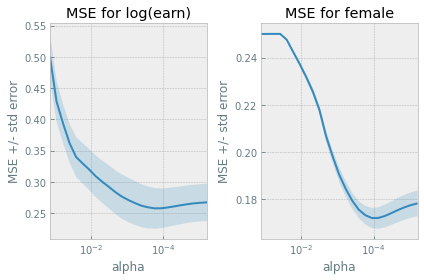

In [27]:
fig, ax = plt.subplots(1,2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MIGHT BE WRONG
def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

In [ ]:
# show results
pl_lasso = partial_linear(logearn, female, X,
                          linear_model.Lasso(alpha=lassoy.alpha_),
                          linear_model.Lasso(alpha=lassod.alpha_))
pl_lasso[0].summary()

In [ ]:
import seaborn as sns
# Visualize predictions
def plotpredictions(pl) :
    df = pd.DataFrame({"logearn":logearn,
                       "predicted":pl[1],
                       "female":female,
                       "P(female|x)":pl[2]})
    sns.pairplot(df, vars=["logearn","predicted"], hue="female")
    plt.title("Observed and predicted log(earnings)")

    plt.figure()
    sns.scatterplot(x = df.predicted, y = df.logearn-df.predicted, hue=df.female)
    plt.title("Prediction Errors")

    plt.figure()
    sns.distplot(pl[2][female==0], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Male")
    sns.distplot(pl[2][female==1], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Female")
    plt.title('P(female|x)')
plotpredictions(pl_lasso)